# Safety First - Hard Hat Detection

---
## Project Proposal

### Team Member

- Stanley Yang
- Lennard Vanderspek 
 
### Description

Workplace safety is very important but often overlooked. Most important way to keep workers 
safe is by wearing a hard hat. This project will utilize Convolution Neural Net and YOLO to help 
detect whether workers are wearing a hard hat or not.

#### Machine Learning Topics Used:

- Convolution Neural Net 
- YOLO 
 
### Expected Outcome

A trained model that is able to detect whether workers are wearing a hard hat or not by 
implementing YOLO using PyTorch. We are hoping to utilize the model to bring more awareness 
to workplace safety.

---

## Use CUDA if Available

In [1]:
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available!  Training on GPU ...")

CUDA is not available.  Training on CPU ...


---
## Load the Data


### Create Custom Dataset Class

In [2]:
from torch.utils.data import Dataset
import cv2
import torchvision.transforms as transforms
import os

# specify the image classes
classes = ['head', 'helmet', 'person']
num_classes = len(classes)

def yolo_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    # Pad labels to the max number of objects in the batch
    max_objs = max(label.shape[0] for label in labels)
    padded_labels = []
    for label in labels:
        pad_size = max_objs - label.shape[0]
        if pad_size > 0:
            # Pad with -1
            padded = torch.nn.functional.pad(label, (0, 0, 0, pad_size), value=-1)
        else:
            padded = label
        padded_labels.append(padded)
    labels = torch.stack(padded_labels, dim=0)
    return images, labels

class custom_dataset(Dataset):
    def __init__(self, image_path, label_path, transform:transforms = None, number_image_to_load=None):
        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform

        if number_image_to_load is None:
            # Load images and labels
            self.images = sorted(os.listdir(image_path))
            self.labels = sorted(os.listdir(label_path))
        else:
            # Load a limited number of images and labels
            self.images = sorted(os.listdir(image_path))[:number_image_to_load]
            self.labels = sorted(os.listdir(label_path))[:number_image_to_load]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_name = self.images[index]
        label_name = self.labels[index]

        # Ensure the label file corresponds to the image file
        if not label_name.startswith(image_name.split('.')[0]):
            raise ValueError(f"Label file {label_name} does not match image file {image_name}")

        # Load the image
        image = cv2.imread(os.path.join(self.image_path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)

        # Load the label
        # Example INPUT with format [class_id, x_center, y_center, width, height]
        # 1 0.502 0.6506024096385542 0.032 0.060240963855421686
        #
        # Example converted OUTPUT with format [x_center, y_center, width, height, confidence, class_0, class_1, class_2]
        # 0.502 0.6506024096385542 0.032 0.060240963855421686 1 0.0 1.0 0.0
        labels = []
        with open(os.path.join(self.label_path, label_name), 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"Skipping invalid label line: {line.strip()}")
                    continue
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Confidence = 1.0 for ground truth
                conf = 1.0

                # One-hot encoding for class
                one_hot_class = [0.0] * num_classes
                one_hot_class[class_id] = 1.0

                # Final label vector
                labels.append([x_center, y_center, width, height, conf] + one_hot_class)

        return image, torch.tensor(labels, dtype=torch.float32)

### Load the Data using Custom Dataset Class

In [3]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

# TODO: Need to adjust the default values

# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# number of images to load (None for all)
number_image_to_load = 2000

# resize the images to this size
image_size = (200, 200)

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Resize(image_size),
    ]
)

# load the data set
train_data = custom_dataset(
    image_path="data-yolo-v7/train/images",
    label_path="data-yolo-v7/train/labels",
    transform=transform,
    number_image_to_load=number_image_to_load,
)
test_data = custom_dataset(
    image_path="data-yolo-v7/test/images",
    label_path="data-yolo-v7/test/labels",
    transform=transform,
    number_image_to_load=number_image_to_load,
)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
    collate_fn=yolo_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
    collate_fn=yolo_collate_fn,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=yolo_collate_fn,
)

### Custom Bounding Box Drawing

In [4]:
import matplotlib.patches as patches


def draw_bounding_boxes(ax, labels, img_size, class_names, color="lime"):
    h, w = img_size

    for box in labels:
        if box[0] == -1:
            continue  # skip padding

        x_center, y_center, box_w, box_h = box[:4]
        class_id = torch.argmax(box[5:]).item()

        # Convert from normalized center coords to top-left corner
        x = (x_center - box_w / 2) * w
        y = (y_center - box_h / 2) * h
        width = box_w * w
        height = box_h * h

        # Draw rectangle
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)

        # Add label text
        ax.text(
            x,
            y - 5,
            class_names[class_id],
            color=color,
            backgroundcolor="black",
            fontsize=10,
        )


### Visualize a Batch of Training Data

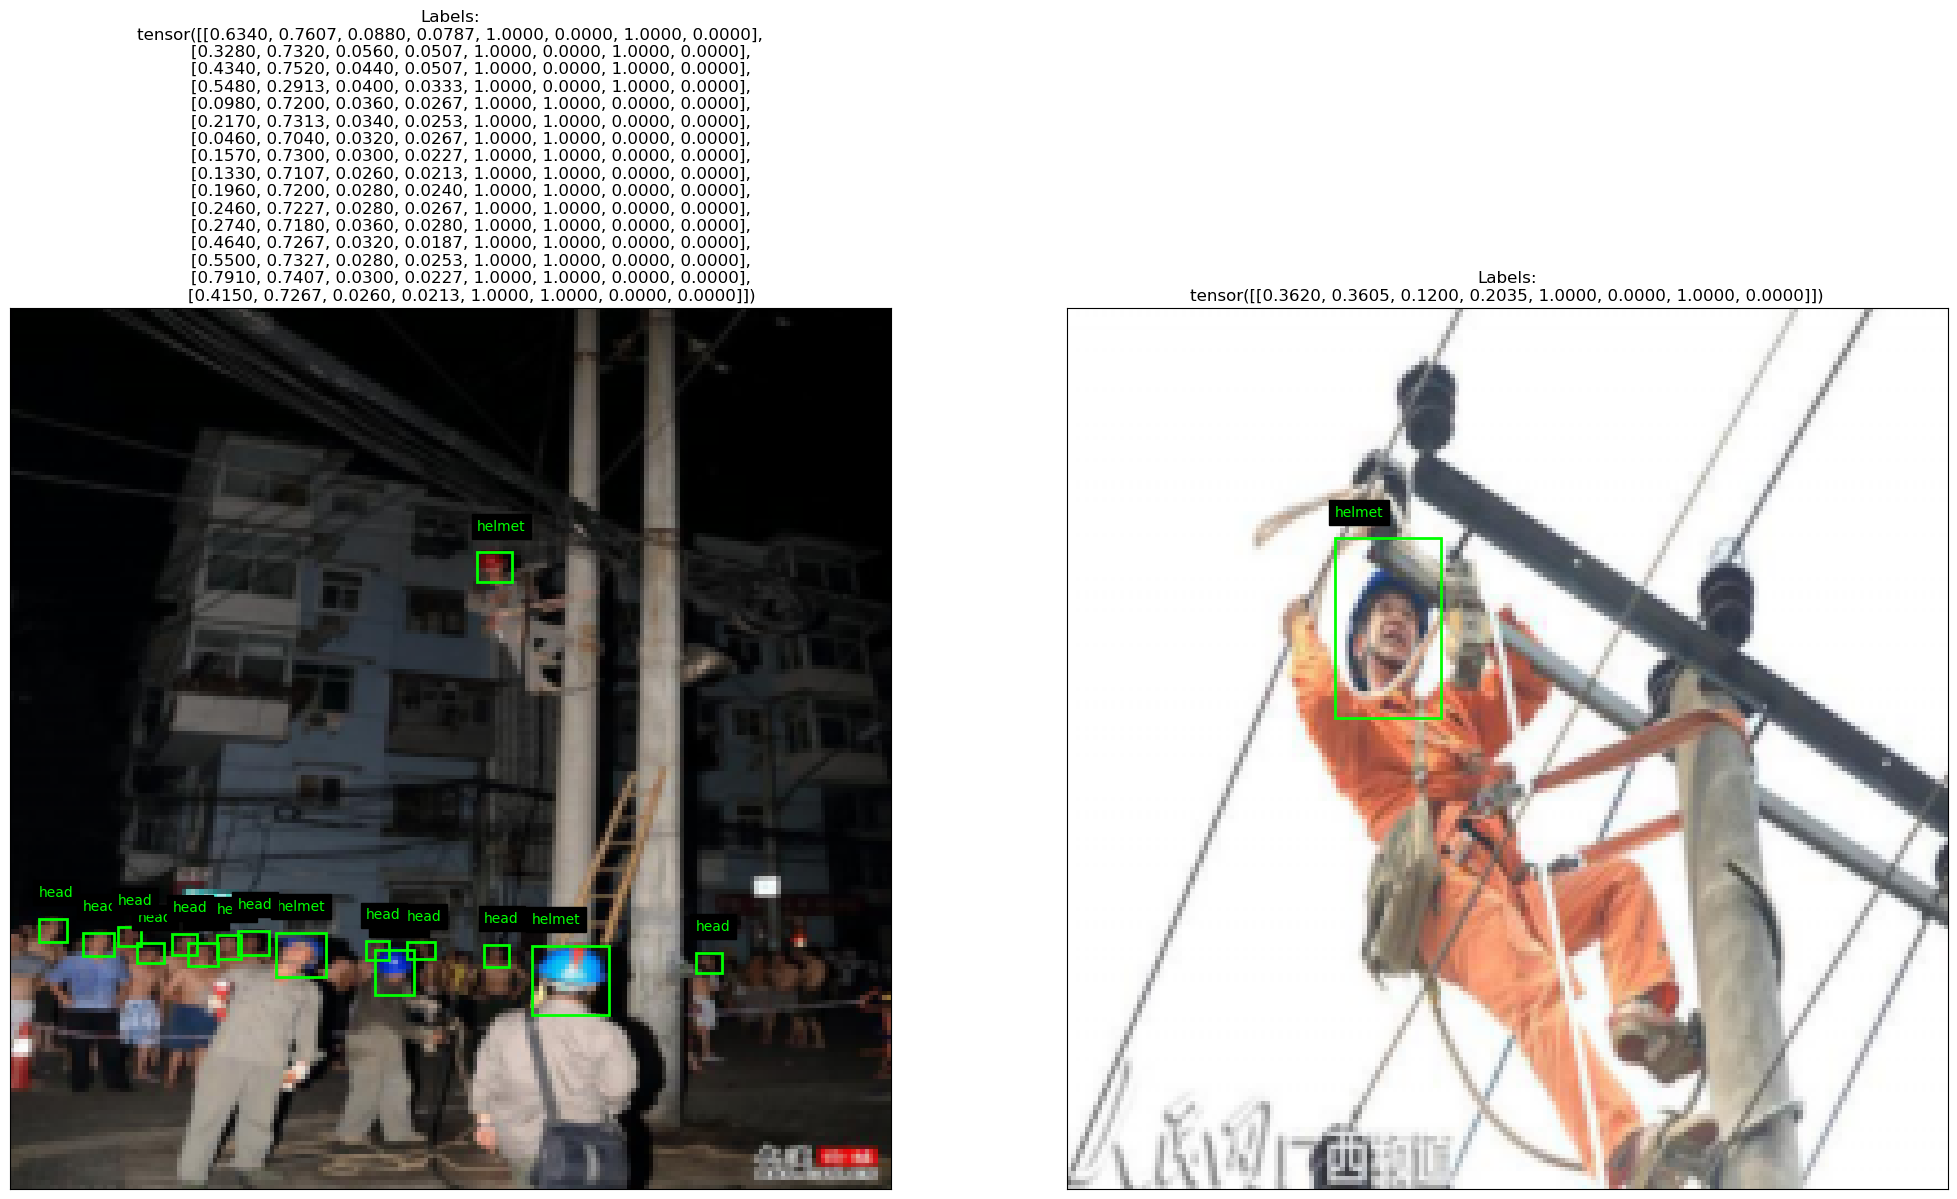

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)

#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 25))

# display 2 images
for idx in range(2):
    ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
    image_np = np.transpose(images[idx], (1, 2, 0))  # shape: (H, W, C)
    image_np = image_np * 0.5 + 0.5  # unnormalize
    ax.imshow(image_np)

    label = labels[idx]
    valid_labels = label[~(label == -1).all(dim=1)]
    draw_bounding_boxes(ax, valid_labels, img_size=(image_np.shape[0], image_np.shape[1]), class_names=classes)

    # filter out padding (rows where all values are -1)
    valid_labels = label[~(label == -1).all(axis=1)]
    ax.set_title(f'Labels:\n{valid_labels}')


### View an Image in More Detail

Showing the normalized red, green, and blue (RGB) color channels as three separate, gray scale intensity images.

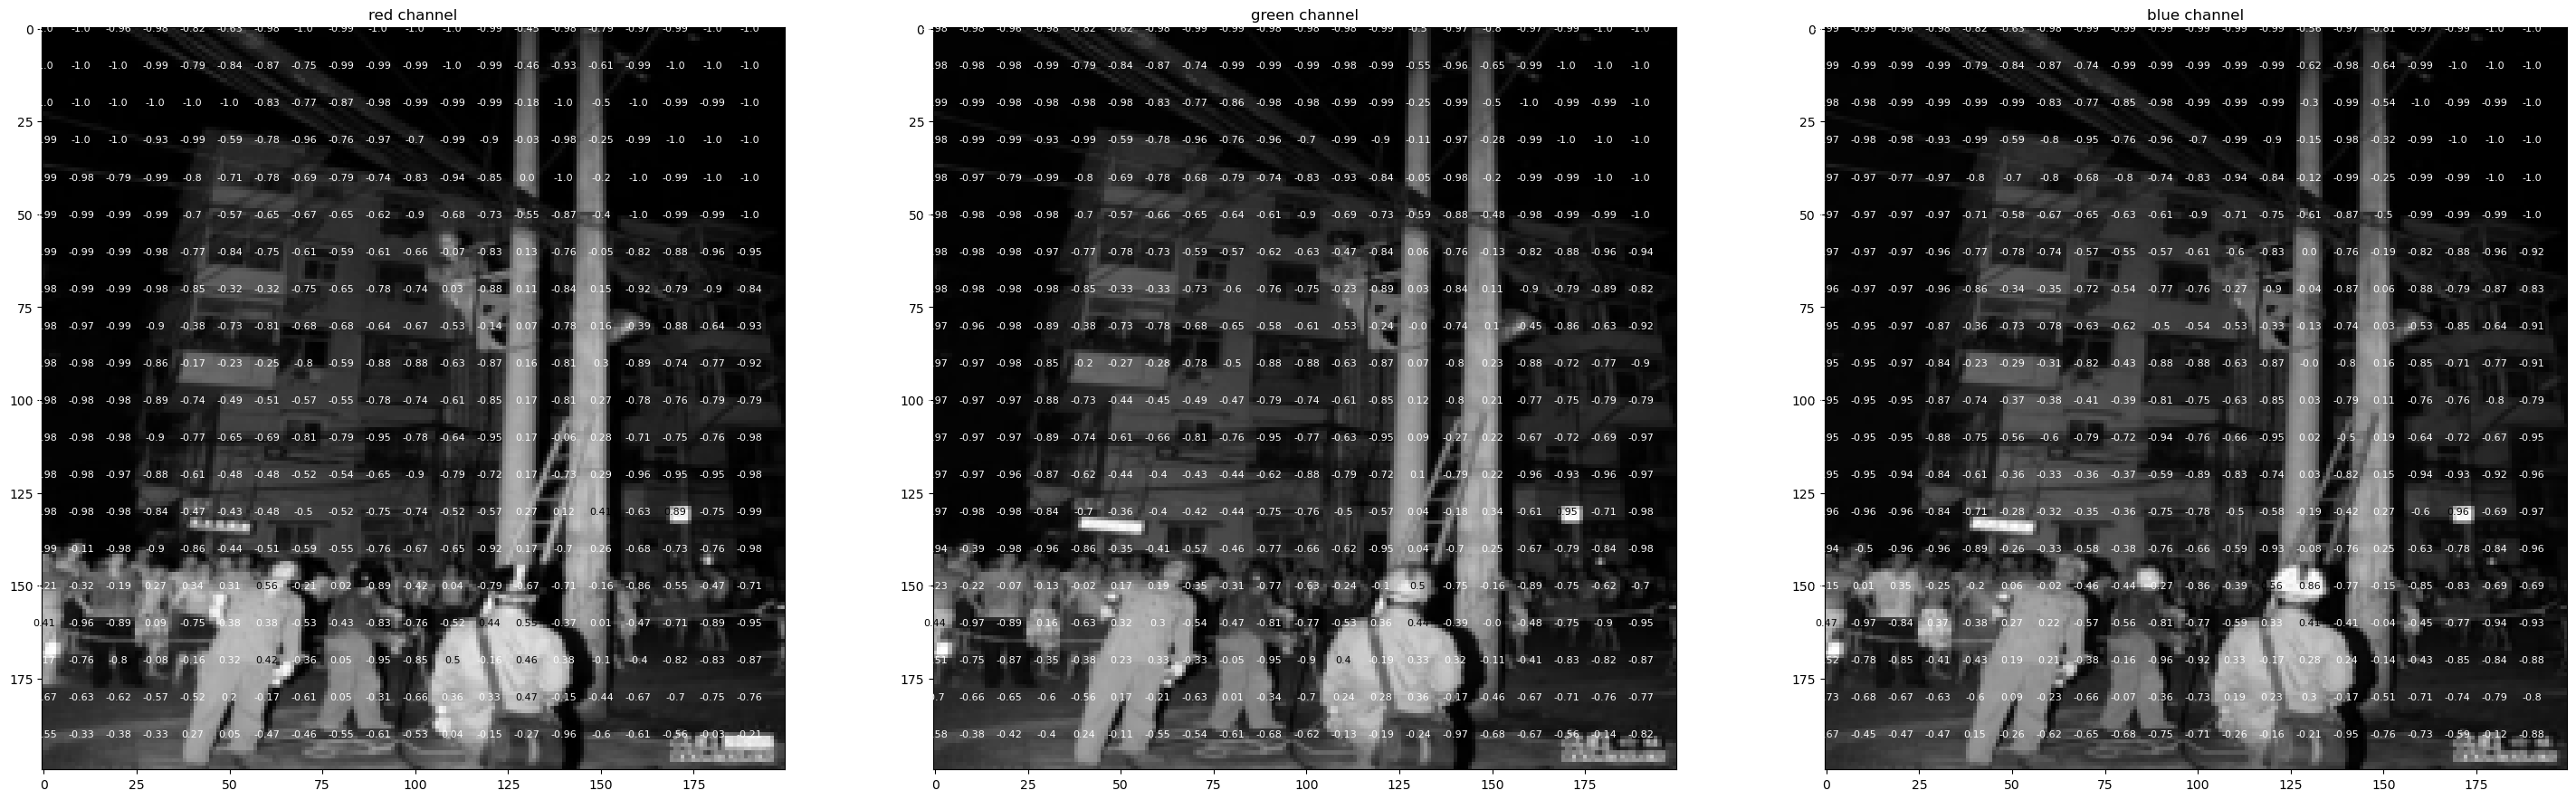

In [6]:
rgb_img = np.squeeze(images[0])
channels = ["red channel", "green channel", "blue channel"]
step = 10  # visualizing in steps of 10 pixels due to large image size

fig = plt.figure(figsize=(36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap="gray")
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(0, width, step):
        for y in range(0, height, step):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(
                str(val),
                xy=(y, x),
                horizontalalignment="center",
                verticalalignment="center",
                size=8,
                color="white" if img[x][y] < thresh else "black",
            )

---
## Define the Network Architecture

In [7]:
import torch.nn as nn


class yolo(nn.Module):
    # default to predict 3 bounding boxes per image and 3 classes
    def __init__(self, num_boxes=3, num_classes=3):
        super(yolo, self).__init__()

        self.num_boxes = num_boxes
        self.num_classes = num_classes
        self.output_dim = self.num_boxes * (
            5 + self.num_classes
        )  # 5 = [x, y, w, h, conf]

        self.convolution_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.detection_layers = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(
                256 * 50 * 50, self.num_boxes * (5 + self.num_classes)
            ),  # 50 is because we have 2 # max pooling layers reducing the size from 200x200 to 50x50
        )

    def forward(self, x):
        features = self.convolution_layers(x)
        predictions = self.detection_layers(features)
        predictions = predictions.view(-1, self.num_boxes, 5 + self.num_classes)
        predictions[..., 4] = torch.sigmoid(predictions[..., 4])
        return predictions


# create a complete CNN
model = yolo()
print(model)

# output total number of parameters
print(
    f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

yolo(
  (convolution_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (detection_layers): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=640000, out_features=24, bias=True)
  )
)
Total parameters: 15731352


---
## Specify Loss Function and Optimizer

### Create Custom Loss Function for YOLO

YOLO loss function is defined as following ([reference](https://www.geeksforgeeks.org/computer-vision/yolov3-from-scratch-using-pytorch/)):

![loss function](yolo_loss_function.png)

In [8]:
# TODO: Need to adjust the default values
LAMBDA_COORD = 1.0
LAMBDA_OBJ = 1.0
LAMBDA_NOOBJ = 1.0
LAMBDA_CLASS = 1.0
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.3

def calculate_iou(pred, target):
    # pred and target are in [x_center, y_center, w, h]
    pred_x1 = pred[0] - pred[2] / 2
    pred_y1 = pred[1] - pred[3] / 2
    pred_x2 = pred[0] + pred[2] / 2
    pred_y2 = pred[1] + pred[3] / 2

    target_x1 = target[0] - target[2] / 2
    target_y1 = target[1] - target[3] / 2
    target_x2 = target[0] + target[2] / 2
    target_y2 = target[1] + target[3] / 2

    inter_x1 = torch.max(pred_x1, target_x1)
    inter_y1 = torch.max(pred_y1, target_y1)
    inter_x2 = torch.min(pred_x2, target_x2)
    inter_y2 = torch.min(pred_y2, target_y2)

    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
    union = pred_area + target_area - inter_area

    return inter_area / union.clamp(min=1e-6)


# TODO: Need to adjust the default values
def custom_loss(predictions, targets, lambda_coord=LAMBDA_COORD, lambda_obj=LAMBDA_OBJ, lambda_noobj=LAMBDA_NOOBJ, lambda_class=LAMBDA_CLASS, confidence_threshold = CONFIDENCE_THRESHOLD, iou_threshold=IOU_THRESHOLD):
    # predictions: [B, N, 5+C]
    # targets: [B, T, 5+C] (padded with -1s)
    B, N, _ = predictions.shape
    total_loss = 0.0

    for i in range(B):
        pred = predictions[i]         # [N, 5+C]
        target = targets[i]           # [T, 5+C]
        T = target.shape[0]

        matched = []
        used_targets = set()

        for pred_i, pred_box in enumerate(pred):
            # Skip predictions with low confidence
            if pred_box[4] < confidence_threshold:
                continue

            top_iou = -1
            top_index = -1
            for target_i, target_box in enumerate(target):
                if target_box[0] == -1 or target_i in used_targets:
                    continue

                iou = calculate_iou(pred_box[:4], target_box[:4])
                if iou > top_iou:
                    top_iou = iou
                    top_index = target_i

            if top_iou > iou_threshold:
                matched.append((pred_i, top_index))
                used_targets.add(top_index)
            else:
                # no-object confidence loss
                noobj_conf_loss = torch.nn.functional.mse_loss(pred_box[4], torch.tensor(0.0, device=pred.device))
                total_loss += lambda_noobj * noobj_conf_loss

        for pred_i, target_i in matched:
            pred_box = pred[pred_i]
            target_box = target[target_i]

            # box loss
            box_loss = torch.nn.functional.mse_loss(pred_box[:4], target_box[:4])

            # object confidence loss
            conf_loss = torch.nn.functional.mse_loss(pred_box[4], target_box[4])

            # classification loss
            class_loss = torch.nn.functional.mse_loss(pred_box[5:], target_box[5:])

            total_loss += lambda_coord * box_loss + lambda_obj * conf_loss + lambda_class * class_loss
        
    return total_loss.clone().detach().requires_grad_(True)

In [9]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = custom_loss

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network



In [10]:
import time
from datetime import timedelta

start_time = time.time()

# TODO: update the number of epochs to train the model
n_epochs = 5

valid_loss_min = np.inf  # track change in validation loss

for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    print("Training...")
    model.train()
    for batch_idx, (images, targets) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, targets = images.cuda(), targets.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)

        # calculate the batch loss
        loss = criterion(output, targets)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # update training loss
        train_loss += loss.item() * images.size(0)

    ######################
    # validate the model #
    ######################
    print("Validating...")
    model.eval()
    for batch_idx, (images, targets) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, targets = images.cuda(), targets.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)

        # calculate the batch loss
        loss = criterion(output, targets)

        # update average validation loss
        valid_loss += loss.item() * images.size(0)

    # calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # print training/validation statistics
    print(f"Training Loss: {train_loss}")
    print(f"Validation Loss: {valid_loss}")

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f"validation loss has decreased from {valid_loss_min} to {valid_loss}")
        print("Validation loss decreased.  Saving model ...")
        torch.save(model.state_dict(), "model_trained.pt")
        valid_loss_min = valid_loss

    print("\n")

end_time = time.time()
total_duration = end_time - start_time
print(f"Total Time for Training: {str(timedelta(seconds=int(total_duration)))}")

Epoch 1/5
Training...
Validating...
Training Loss: 15.788805019855499
Validation Loss: 15.527329206466675
validation loss has decreased from inf to 15.527329206466675
Validation loss decreased.  Saving model ...


Epoch 2/5
Training...
Validating...
Training Loss: 15.774436557292939
Validation Loss: 15.859209680557251


Epoch 3/5
Training...
Validating...
Training Loss: 15.785710215568542
Validation Loss: 15.833075046539307


Epoch 4/5
Training...
Validating...
Training Loss: 15.780751276016236
Validation Loss: 15.841385841369629


Epoch 5/5
Training...
Validating...
Training Loss: 15.783513581752777
Validation Loss: 15.855078935623169


Total Time for Training: 0:03:14


---
## Load the Model with the Lowest Validation Loss

In [11]:
model.load_state_dict(torch.load('model_trained.pt'))

/var/folders/xh/7w1r7x1j6h1gs_g09rn7gtr40000gn/T/ipykernel_78711/1778899561.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_train

<All keys matched successfully>

---
## Test the Trained Network

In [12]:
# track test loss
test_loss = 0.0
class_correct = [0. for _ in range(num_classes)]
class_total = [0. for _ in range(num_classes)]

model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    with torch.no_grad():
        output = model(data)

    # calculate the batch loss
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)

    batch_size = data.size(0)

    for b in range(batch_size):
        preds = output[b]       # shape: [N, 5 + num_classes]
        labels = target[b]      # shape: [M, 5 + num_classes]

        labels = labels[labels[:, 4] != -1]  # remove padding

        for gt in labels:
            gt_class = torch.argmax(gt[5:]).item()
            best_iou = 0
            best_pred_class = None

            filtered_preds = preds[preds[:, 4] > CONFIDENCE_THRESHOLD]

            for pred in filtered_preds:
                iou = calculate_iou(pred[:4], gt[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_pred_class = torch.argmax(pred[5:]).item()

            if best_iou > IOU_THRESHOLD:
                class_total[gt_class] += 1
                if best_pred_class == gt_class:
                    class_correct[gt_class] += 1

# average test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no ground truth samples)' % (classes[i]))

if sum(class_total) > 0:
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * sum(class_correct) / sum(class_total),
        sum(class_correct), sum(class_total)))
else:
    print('\nTest Accuracy (Overall): N/A (no valid ground truth boxes in test set)')

Test Loss: 15.356558

Test Accuracy of  head: N/A (no ground truth samples)
Test Accuracy of helmet: 40% ( 2/ 5)
Test Accuracy of person: N/A (no ground truth samples)

Test Accuracy (Overall): 40% ( 2/ 5)


## Visualize Sample Test Results


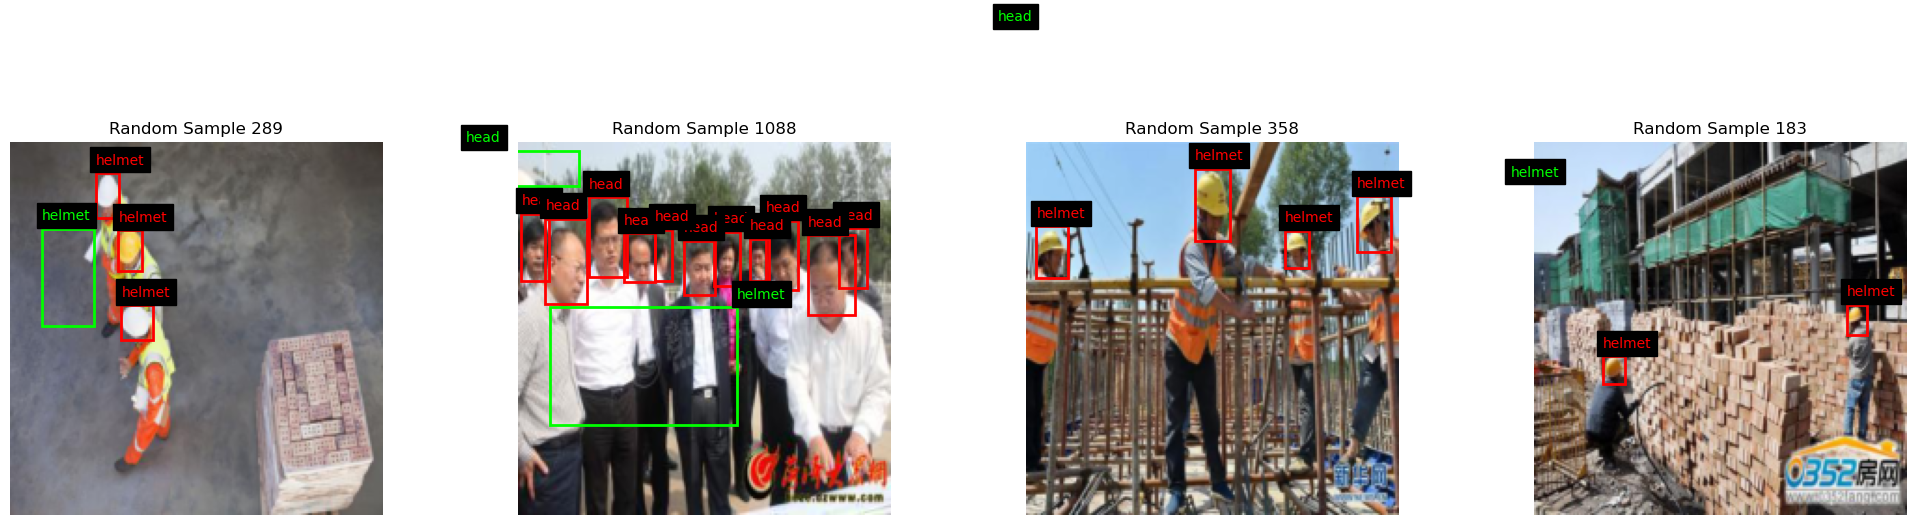

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random


def draw_bounding_boxes(ax, labels, img_size, class_names, color="lime"):
    h, w = img_size
    for box in labels:
        if box[0] == -1:
            continue  # skip padding
        x_center, y_center, box_w, box_h = box[:4]
        class_id = torch.argmax(box[5:]).item()
        x = (x_center - box_w / 2) * w
        y = (y_center - box_h / 2) * h
        width = box_w * w
        height = box_h * h
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(
            x,
            y - 5,
            class_names[class_id],
            color=color,
            backgroundcolor="black",
            fontsize=10,
        )


# Collect all test samples into memory for random access
all_images = []
all_targets = []

for images, targets in test_loader:
    all_images.extend(images)
    all_targets.extend(targets)

# Choose N random indices
N = 4
indices = random.sample(range(len(all_images)), k=N)

fig, axs = plt.subplots(1, N, figsize=(5 * N, 5))
if N == 1:
    axs = [axs]

model.eval()
for i, idx in enumerate(indices):
    image = all_images[idx].unsqueeze(0).to(next(model.parameters()).device)
    target = all_targets[idx].to(image.device)

    with torch.no_grad():
        output = model(image)[0].cpu()

    img = image[0].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)
    ax = axs[i]
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Random Sample {idx}")

    # Draw predicted and ground truth boxes
    output = output[output[:, 4] > 0.5]  # confidence filter
    draw_bounding_boxes(ax, output, img.shape[:2], classes, color="lime")
    draw_bounding_boxes(ax, target.cpu(), img.shape[:2], classes, color="red")

plt.tight_layout()
plt.show()